# Test Model Version

Google Colab (where models are trained) automatically update packages from time to time. This notebook is to test, if models will work, with version in requirements file.

In [1]:
import pickle
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.tree import DecisionTreeRegressor

import sklearn
print(sklearn.__version__)

1.0.1


In [2]:

def data_preparation(df, names):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index(['Timestamp', 'Name']).stack().reset_index()
    df = df.rename(columns={'level_2': 'direction', 0: 'count'})
    df['direction'] = df['direction'].astype('category')

    df['year'] = df['Timestamp'].dt.year

    df['hour'] = df['Timestamp'].dt.hour

    df['weekday'] = df['Timestamp'].dt.weekday

    df['minute'] = df['Timestamp'].dt.minute

    df['month'] = df['Timestamp'].dt.month

    df['day'] = pd.to_datetime(df['Timestamp'].dt.date)

    df['direction_cat'] = df['direction'].replace({'In': 0, 'Out': 1})

    df['name_cat'] = df['Name'].replace(names)

    return df


def plot_day(df, day, name, regressor, XList):
    df_filter = df[(df['day'] == day) & (df['Name'] == name)].copy()
    df_filter['prediction'] = regressor.predict(df_filter[XList])
    melted = df_filter.melt(id_vars=['Timestamp', 'direction', 'Name'], value_vars=['count', 'prediction'])
    melted['value'] = melted['value'].astype(float)
    fig = px.line(melted, x='Timestamp', y='value', color='variable', facet_row='direction', title=name)
    return fig


def create_date_range(date, freq='5min'):
    return pd.date_range('{} 00:00:00'.format(date), '{} 23:55:00'.format(date), freq=freq)


def create_future_df(name, date):
    future = pd.DataFrame({'Timestamp': create_date_range(date), })
    future['In'] = 0
    future['Out'] = 0
    # future = future.set_index('Timestamp').stack().reset_index().drop(columns=0)
    # future = future.rename(columns={'level_1':'direction'})
    future['Name'] = name
    return future


def download_from_api(date, resource):
    url_day = """https://data.stadt-zuerich.ch/api/3/action/datastore_search_sql?""" \
        """sql=SELECT%20%22Timestamp%22,%22Name%22,%22In%22,%22Out%22%20""" \
        """from%20%22{resource}%22""" \
        """where%20%22Timestamp%22::TIMESTAMP::DATE=%27{day}%27%20;"""
    df = pd.read_json(url_day.format(day=date, resource=resource)).loc['records', 'result']
    df = pd.DataFrame.from_dict(df)  # .drop(columns=['_full_text','_id'])
    if df.empty:
        data_available = False
    else:
        data_available = True
    return data_available, df


def get_from_api(url):
    """
    Download from api. For historical data
    :param url:
    :return:
    """
    df = pd.read_json(url).loc['records', 'result']
    df = pd.DataFrame.from_dict(df)  # .drop(columns=['_full_text','_id'])
    if df.empty:
        data_available = False
    else:
        data_available = True
    return data_available, df

def update_plots_tab1(date, location_name):
    # check if historical data is available
    # if False:  # dates_min <= date <= dates_max:
    #     plot_df = hb2
    year = date[0:4]
    if year in resource_api:
        resource_year = resource_api[year]
        # data from api
        data_available, df_api = download_from_api(date, resource_year)
        if data_available:
            plot_df = data_preparation(df_api, names)
        else:
            future = data_preparation(create_future_df(location_name, date), names)
            future['count'] = np.nan  # no real data available
            plot_df = future
    else:
        future = data_preparation(create_future_df(location_name, date), names)
        future['count'] = np.nan  # no real data available
        plot_df = future
    return plot_day(plot_df, date, location_name, regressor, XList)


In [3]:
# parameters
names = {
    'Ost-Süd total': 0,
    'Ost-Sd total': 0,  # alias, as seen in api query
    'Ost-Nord total': 1,
    'Ost-SBB total': 2,
    'West-SBB total': 3,
    'West-Süd total': 4,
    'West-Sd total': 4,  # alias, as seen in api query
    'Ost-VBZ Total': 5,
    'West-Nord total': 6,
    'West-VBZ total': 7,
}

XList = [
    'year',
    'hour',
    'weekday',
    'minute',
    'month',
    'direction_cat',
    'name_cat',
]
y = 'count'

resource_api = {
    '2022': """a0c89c3e-72e7-4cbe-965a-efa16b3ecd5f""",
    '2021': """2f27e464-4910-46bf-817b-a9bac19f86f3""",
    '2020': """5baeaf58-9af2-4a39-a357-9063ca450893""",
}


In [10]:
# load model
filename_model = '../models/DecisionTreeRegressor.sav'
#filename_model = '../models/archive/2021-08-22_DecisionTreeRegressor.sav'
regressor = pickle.load(open(filename_model, 'rb'))

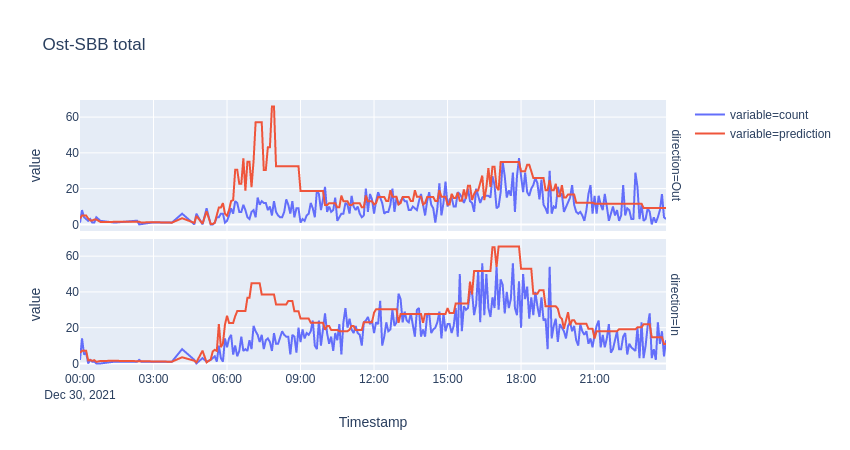

In [12]:
update_plots_tab1('2021-12-30', 'Ost-SBB total')